In [1]:
from collections import defaultdict
import pandas as pd
import MySQLdb
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

'''
    We're using RegulonDB to scrape data of genes and operons 
    from e.coli genome in order to calculate intergenic distance 
    between genes within operons and distance between genes 
    at the border of operons.
    
    Intergenic distances found within operons will be positive control
    Intergenic distance found between genes at operon borders will 
    be negative control. 
    
    We will use naive bayesian model to predict how likely
    the intergenic distance between two genes will lead
    to operon membership for the two genes. 
    
    After building the model, we wil benchmark the model 
    to find the threshold to predict operon membership
'''

In [2]:
# build the gene dictionary to map the gene name to locus tag
gene_dict = defaultdict(str)

with open('data/GeneProductSet.txt') as f:
    f = f.readlines()[38:]
    
    # map the the gene to locus tag
    for line in f:
        line = line.strip('\n').split('\t')
        gene_dict[line[1]] = line[2]

In [3]:
# scrape the operons from RegulonDB
operons = []

with open('data/OperonSet.txt') as f:
    # skip the headers and read everything else
    f = f.readlines()[36:]
    
    # iterate through every operon
    for line in f:
        line = line.strip('\n').split('\t')
        
        # ignore operons that are weak.
        # we do this so we can build a more confident model
        if line[-1] in ['Weak', '']:
            continue
        
        operons.append({
            'name': line[0],
            'genes': line[5].split(','),
            'status': line[-1]
        })

In [4]:
# iterate through all the operons and annotate each set of
# genes with their locus tag
for i in xrange(len(operons)):
    genes = operons[i]['genes']    
    genes = [gene_dict[gene] for gene in genes]
    
    operons[i]['genes'] = genes

In [5]:
# Set up the python binding for MySQL db
db = MySQLdb.connect(host='localhost',
                     user='root',
                     passwd='REDACTED',
                     db='REDACTED')
curr = db.cursor()

In [6]:
# build our positive controls with distances between genes within operons
positive_controls = []

# SQL statement to get coordinates of all genes with operons
query = "SELECT g.gene_id,e.left_position,e.right_position,g.strand  FROM genes g JOIN exons e USING(gene_id) WHERE g.locus_tag IN (XXXX) ORDER BY e.left_position ASC"

for operon in operons:    
    # modify the query statement to hold the locus tags
    genes = ','.join(map(str, [("'" + gene + "'") for gene in operon['genes']]))
    q = query.replace('XXXX', genes)
        
    curr.execute(q)
    result = curr.fetchall()
    
    # sort the results according to their left position
    result = [{'left': left, 'right': right, 'strand': strand, 'gene_id': gene_id} for (gene_id, left, right, strand) in result]
    result = sorted(result, key=lambda x: x['left'])

    # skip this operon if there are no hits in the database
    # possibly tRNA instead of a coding sequence
    if len(result) == 0:
        continue
    
    operon['coordinates'] = result
    
    # ignore all operons with one gene only
    if len(operon['genes']) < 2:
        continue
        
    # get the distances between genes 
    for i in xrange(len(result)-1):
        geneA = result[i]
        geneB = result[i+1]
        
        dist = geneB['left'] - geneA['right'] + 1
        positive_controls.append(dist)

In [7]:
# build our negative control with distances between genes at the operon border
negative_controls = []

# SQL statemtnt to get all the genes from the databse sorted the exon's left position of each gene.
query = "SELECT @a:=@a+1 as idx, g.gene_id,e.left_position,e.right_position,g.strand  FROM genes g JOIN exons e USING(gene_id) WHERE g.genome_id=0 ORDER BY e.left_position ASC;"

# execute the SQL statements
curr.execute('SET @a:=0')
curr.execute(query)

# turn it into a Panda table to make it easier to query genes
result = list(curr.fetchall())
df = pd.DataFrame.from_records(result, columns=['idx', 'gene_id', 'left_position', 'right_position', 'strand'])

for operon in operons:
    # check if the operon has valid coding sequences
    # by seeing if they're annotated with coordinates
    if 'coordinates' not in operon.keys():
        continue
    
    # get the gene id and query against the dataframe in order to
    # get their index number
    geneA = operon['coordinates'][0]['gene_id']
    geneB = operon['coordinates'][-1]['gene_id']
    
    geneA = df.loc[df['gene_id'] == geneA]
    geneB = df.loc[df['gene_id'] == geneB]
    
    geneAIdx = geneA['idx'].values[0]
    geneBIdx = geneB['idx'].values[0]
    
    beforeGeneA = df.loc[df['idx'] == (geneAIdx-1)]
    afterGeneB = df.loc[df['idx'] == (geneBIdx+1)]

    if not beforeGeneA.empty:
        if geneA['strand'].values[0] == beforeGeneA['strand'].values[0]:
            dist = geneA['left_position'].values[0] - beforeGeneA['right_position'].values[0]
        negative_controls.append(dist)
    if not afterGeneB.empty:
        if geneB['strand'].values[0] == afterGeneB['strand'].values[0]:
            dist = afterGeneB['left_position'].values[0] - geneB['right_position'].values[0]
            negative_controls.append(dist)

In [11]:
# write down the the numbers from the positive controls and negative controls in to text files
# so we can recreate the model later. 
with open('output/pos_ctrl.txt', 'w') as WRITER:
    pos = '\t'.join(map(str, positive_controls))
    WRITER.write(pos+'\n')
with open('output/neg_ctrl.txt', 'w') as WRITER:
    neg = '\t'.join(map(str, negative_controls))
    WRITER.write(neg + '\n')

In [8]:
# generate the log liklihood out of the positive and negative control
LL_h1 = gaussian_kde(positive_controls)
LL_h0 = gaussian_kde(negative_controls)

# build our model
def model(x):
    num = LL_h1(x)*0.60
    den = LL_h0(x)*0.40 + num
    
    return (num/den)

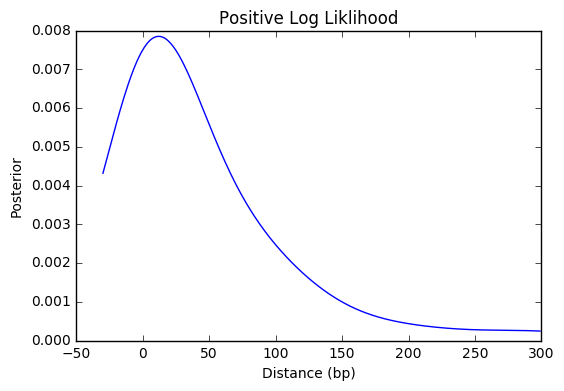

In [9]:
# Our graph showcasing the positive control control logliklihood

x = [i for i in xrange(-30, 300)]
y = [LL_h1(i)[0] for i in xrange(-30, 300)]

plt.plot(x,y)
plt.title('Positive Log Liklihood')
plt.xlabel('Distance (bp)')
plt.ylabel('Posterior')
plt.savefig('output/pos_log.png')
plt.show()

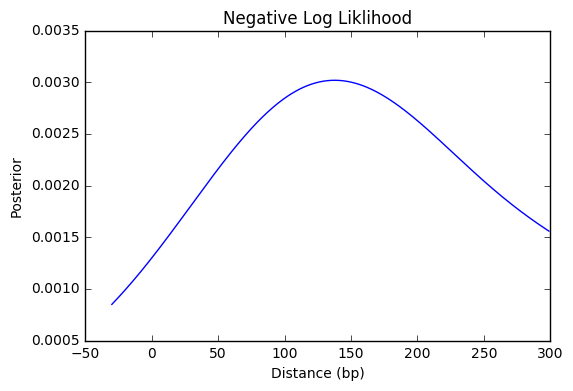

In [10]:
# Our graph showcasing the negative control control logliklihood

x = [i for i in xrange(-30, 300)]
y = [LL_h0(i)[0] for i in xrange(-30, 300)]

plt.plot(x,y)
plt.title('Negative Log Liklihood')
plt.xlabel('Distance (bp)')
plt.ylabel('Posterior')
plt.savefig('output/neg_log.png')
plt.show()

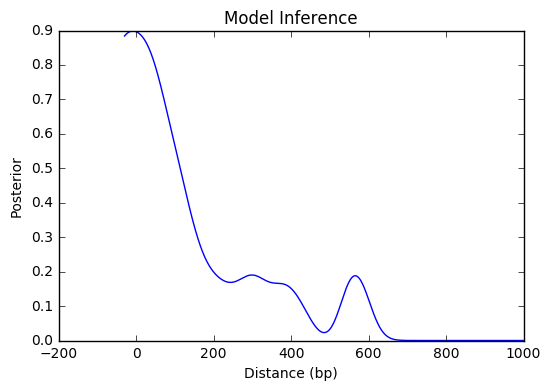

In [11]:
# Our graph showcasing the model's inference

x = [i for i in xrange(-30, 1000)]
y = [model(i)[0] for i in xrange(-30, 1000)]

plt.plot(x,y)
plt.title('Model Inference')
plt.xlabel('Distance (bp)')
plt.ylabel('Posterior')
plt.savefig('output/model.png')
plt.show()

In [12]:
# build our predictions off our newly made model and benchmark it
predictions = []

# make the predictions on all the true positives

# SQL statement to get coordinates of all genes with operons
query = "SELECT g.gene_id,e.left_position,e.right_position,g.strand  FROM genes g JOIN exons e USING(gene_id) WHERE g.locus_tag IN (XXXX) ORDER BY e.left_position ASC"

for operon in operons:    
    # modify the query statement to hold the locus tags
    genes = ','.join(map(str, [("'" + gene + "'") for gene in operon['genes']]))
    q = query.replace('XXXX', genes)
        
    curr.execute(q)
    result = curr.fetchall()
    
    # sort the results according to their left position
    result = [{'left': left, 'right': right, 'strand': strand, 'gene_id': gene_id} for (gene_id, left, right, strand) in result]
    result = sorted(result, key=lambda x: x['left'])

    # skip this operon if there are no hits in the database
    # possibly tRNA instead of a coding sequence
    if len(result) == 0:
        continue
        
    # ignore all operons with one gene only
    if len(operon['genes']) < 2:
        continue
            
    # get the distances between genes 
    for i in xrange(len(result)-1):
        geneA = result[i]
        geneB = result[i+1]
        
        dist = geneB['left'] - geneA['right'] + 1
        predictions.append({
            'gid_1': geneA['gene_id'],
            'gid_2': geneB['gene_id'],
            'distance': dist,
            'status': 'TP',
            'prob': model(dist)[0]
        })

In [13]:
# make prediction of all the true negatives
for operon in operons:
    # check if the operon has valid coding sequences
    # by seeing if they're annotated with coordinates
    if 'coordinates' not in operon.keys():
        continue
    
    # get the gene id and query against the dataframe in order to
    # get their index number
    geneA = operon['coordinates'][0]['gene_id']
    geneB = operon['coordinates'][-1]['gene_id']
    
    geneA = df.loc[df['gene_id'] == geneA]
    geneB = df.loc[df['gene_id'] == geneB]
    
    geneAIdx = geneA['idx'].values[0]
    geneBIdx = geneB['idx'].values[0]
    
    beforeGeneA = df.loc[df['idx'] == (geneAIdx-1)]
    afterGeneB = df.loc[df['idx'] == (geneBIdx+1)]

    if not beforeGeneA.empty:
        if geneA['strand'].values[0] == beforeGeneA['strand'].values[0]:
            dist = geneA['left_position'].values[0] - beforeGeneA['right_position'].values[0]
            gid_1 = geneA['gene_id'].values[0]
            gid_2 = beforeGeneA['gene_id'].values[0]
            
            predictions.append({
                'gid_1': gid_1,
                'gid_2': gid_2,
                'status': 'TN',
                'dist': dist,
                'prob': model(dist)[0]
            })
            
            
    if not afterGeneB.empty:
        if geneB['strand'].values[0] == afterGeneB['strand'].values[0]:
            dist = afterGeneB['left_position'].values[0] - geneB['right_position'].values[0]
            gid_1 = afterGeneB['gene_id'].values[0]
            gid_2 = geneB['gene_id'].values[0]

            predictions.append({
                'gid_1': gid_1,
                'gid_2': gid_2,
                'status': 'TN',
                'dist': dist,
                'prob': model(dist)[0]
            })

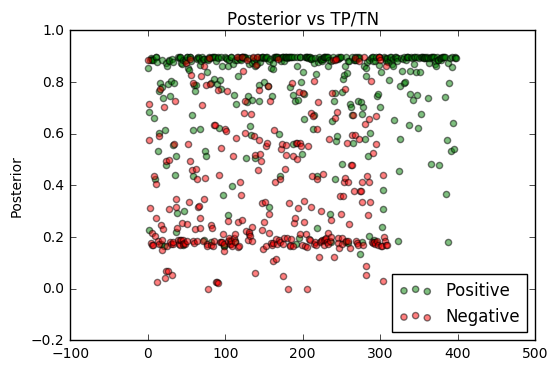

In [14]:
# Seperate the true positives from the true negatives into their posterior probabilities
tp = []
tn = []
for prediction in predictions:
    if prediction['status'] == 'TP':
        tp.append(prediction['prob'])
    if prediction['status'] == 'TN':
        tn.append(prediction['prob'])
    
# graph the model predictions througha  scatter plot
# to get a better idea of what threshold we might want to start
# off an increment

# true positives
x = [i for i in xrange(len(tp))]
y = tp

pos = plt.scatter(x, y, c=['green'], alpha=0.5)

x = [i for i in xrange(len(tn))]
y = tn

neg = plt.scatter(x, y, c=['red'], alpha=0.5)
plt.legend((pos, neg), ('Positive', 'Negative'), loc='lower right',)
plt.ylabel('Posterior')
plt.title('Posterior vs TP/TN')
plt.savefig('output/scatter.png')
plt.show()

In [15]:
# we're going to start with a threshold of 0.10 for classifying as positive
# and increment by 0.05 everytime to see which threshold gives us the better
# value

# helper function to give us specificy, sensitivity, precision, and etc rate 
# based on threshold
def stats(threshold):
    TP = []
    TN = []
    FP = []
    FN = []
    
    for prediction in predictions:
        pred = 'P' if prediction['prob'] >= threshold else 'N'
        truth = 'P' if prediction['status'] == 'TP' else 'N'
        
        # true positive or true negagtive
        if pred == truth:
            # true positive
            if prediction['status'] == 'TP':
                TP.append(1)
            # true negative
            else:
                TN.append(1)
        # false positive or false negative
        else:
            # false positive
            if pred == 'P':
                FP.append(1)
            else:
                FN.append(1)
    
    sensitivity = sum(TP)/(float(sum(TP) + sum(FN)))                
    specificity = sum(TN)/(float(sum(TN) + sum(FP)))
    precision = sum(TP)/float(sum(TP) + sum(FP)) if (sum(FP) + sum(TP)) > 0 else 1
    accuracy = (sum(TP) + sum(TN))/float(sum(TP)+sum(TN)+sum(FP)+sum(FN))
    fpr = sum(FP)/(float(sum(TN) + sum(FP)))                
    
    return sensitivity, specificity, precision, accuracy, fpr

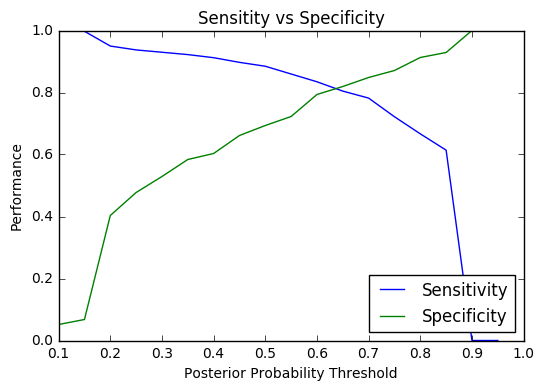

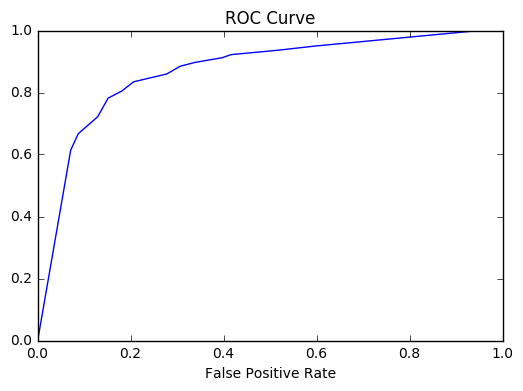

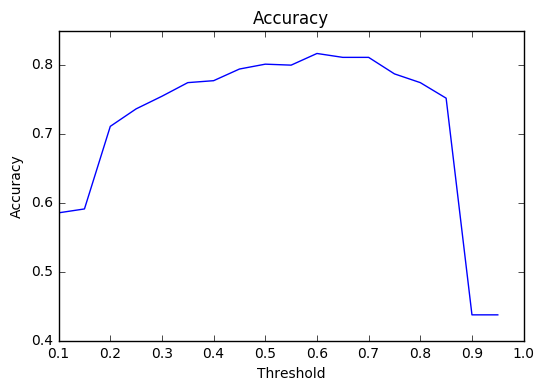

In [16]:
# list of thresholds to benchmark our model against
thresholds = np.arange(0.1, 1.0, 0.05)
sens, spec, prec, acc, fpr = zip(*[stats(threshold) for threshold in thresholds])

# build our graphs
plt.plot(thresholds, sens)
plt.plot(thresholds, spec)
plt.legend(('Sensitivity', 'Specificity'), loc='lower right',)
plt.ylabel('Performance')
plt.xlabel('Posterior Probability Threshold')
plt.title('Sensitity vs Specificity')
plt.savefig('output/sens_spec.png')
plt.show()

plt.plot(fpr, sens)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.savefig('output/roc.png')
plt.show()

plt.plot(thresholds, acc)
plt.title('Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.savefig('output/acc.png')
plt.show()